<a href="https://colab.research.google.com/github/JpChii/nlp-with-hugging-face/blob/main/notebooks/8-Making-transformers-efficient-in-production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making Transformers Efficient in Production

In previous notebooks, we've seen how transformers can be fine-tuned for various tasks. However in many situations irrespective of the metric, model is not very useful if it's too slow or too large to meet the buisness requirements of the application. The obvious alternative is to train a faster and more compact model, but with reduction comes the degradation in performance. What if we need a compact yet highly accurate model?

In this notebook we'll cover four techniques with Open Neural Network Exchange(ONNX) and ONNX Runtime(ORT) to reduce the prediction time and memory footprint of the transformers, they are:

  1. *Knowledge distillization*
  2. *Quantization*
  3. *Pruning*
  4. *Graph Optimization*

We'll also see how the techniques can be combined to produce significant performance gains. [How Roblox engineering team scaled Bert to serve 1+ Billion Daily Requests on CPUs](https://medium.com/@quocnle/how-we-scaled-bert-to-serve-1-billion-daily-requests-on-cpus-d99be090db26) and found that knowledge distillization and quantization improved the latency and throughput of their BERT classifier over a factor of 30!

To illustrate the benefits and tradeoffs associated with each technique, we'll use intent detection(important component of text-based assistants), where low latency is critical for maintaining a conversation in real time.
Along the way, we'll also learn how to create custom trainers and perform hyperparamter search, and gain a sense of what it takes to implement cutting-edge research with Transformers(lib).

## Intent Detection as a Case Study

Let's suppose we're trying to build a text-based assistant for a company's call center to deal with banking and bookings without human interaction. Base on a wide variety of natural language text(input from user), our assistant needs to classify the input into a set of predefiend actions or *intents*.

For example:

*Message*: Hey, i'd like to rent a vehichle on Nov1st.

The assitant will classify this as *car rental intent* which then triggers an action and an response.

The assistance must also have the ability to identify out of scope(oos) intents to be robust in a production environment.

As a baseline, a BERT-model has been fine-tuned with accuracy around 94% on [CLINIC150 dataset](https://arxiv.org/abs/1909.02027). This dataset includes 22,500 inscope queries across 150 intents and 10 domains like banking and travel, and also includes 1,200 *oos* intent class.

> **Note:** In practive, we would gather in-house dataset, but using public data is a greate way to iterate quickly and generate preliminary results.

First let's load the model and wrap it around a text-classification pipeline.

In [ ]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline(
    task="text-classification",
    model=bert_ckpt
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

The intent is good, as usual let's create a benchmark to evaluate the performance for our baseline model.

## Creating a Performance Benchmark

Like other machine learning models, deploying transformers in production environments involves trade-off among several constraints, the most common being:

*Model Performance*

How well does our model perform on a well-crafted test set that reflects production data? This is especially important when the cost of making erros is large(and best mitigated with a human in the loop) or running inference on millions of examples and small improvements to the model metrics can translate into large gains in aggregate.

*Latency*

How fast can our model deliver predictions? We usually care about latency in a real-time environment where we deail with a lot of traffic, like how stack overfloww needed a classifier to quickly [detect unwelcome comments on the website](https://stackoverflow.blog/2020/04/09/the-unfriendly-robot-automatically-flagging-unwelcoming-comments/)

*Memory*

How can we deploy billion-parameter models like GPT or T5 which requires gigabytes of disk storage and RAM? Memory plays an important role in mobile and edge devices, where we've to generate predictions without a cloud server.

Failing to address these constrains might result in:

* Poor user experience
* Balooned cloud costs for just a few user requests

To explore how the 4 different compression techniques can be used to optimizer these. Let's create a benchmark class which measures each of these quantities for a given pipeline and a test set.

In [ ]:
# Skeleton of the benchmark
class PerformanceBenchmark:
  def __init__(
      self,
      pipeline,
      dataset,
      optim_type="BERT baseline"
  ):
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type

  def compute_accuracy(self):
    # Performance
    pass

  def compute_size(self):
    # Memory
    pass

  def time_pipeline(self):
    # Latency
    pass

  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

We've define `optim_type` to store results of different optimization techniques. `run_benchmark()` function to collect the metrics in a dictionary.

Let's add some flesh to the skeleton by evaluating accuracy for our baseline model on the CLINC150 dataset. Let's download it.

In [ ]:
dataset_path = "clinc_oos"
from datasets import get_dataset_config_names
get_dataset_config_names(
    path=dataset_path
)

Downloading:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

['small', 'imbalanced', 'plus']

In [ ]:
# We'll  use the plus subset
from datasets import load_dataset
clinc = load_dataset(
    path=dataset_path,
    name="plus",
)

Downloading:   0%|          | 0.00/291k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [ ]:
clinc["test"][2]

{'text': 'how would they say butter in zambia', 'intent': 61}

`plus` subset contains *oos* intents. Each example in the dataset has text and intent.

In [ ]:
clinc["test"].features['intent']

ClassLabel(num_classes=151, names=['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations', 'smart_home', 'user_name', 'report_lost_card', 'repeat', 'whisper_mode', 'what_are_your_hobbies', 'order', 'jump_start', 'schedule_meeting', 'meeting_schedule', 'freeze_account', 'what_song', 'meaning_of_life', 'restaurant_reservation', 'traffic', 'make_call', 'text', 'bill_balance', 'improve_credit_score', 'change_language', 'no', 'measurement_conversion', 'timer', 'flip_coin', 'do_you_have_pets', 'balance', 'tell_joke', 'last_maintenance', 'exchange_rate', 'uber', 'car_rental', 'credit_limit', 'oos', 'shopping_list', 'expiration_date', 'routing', 'meal_suggestion', 'tire_change', 'todo_list', 'card_declined', 'rewards_balance', 'change_accent', 'vaccines', 'reminder_update', 'food_last', 'change_ai_name', 'bill_due', 'who_do_you_work_for', 'share_location', 'international_visa', 'calend

In [ ]:
intents = clinc["test"].features["intent"]

In [ ]:
int2str = {i:s for i, s in enumerate(intents.names)}
int2str

{0: 'restaurant_reviews',
 1: 'nutrition_info',
 2: 'account_blocked',
 3: 'oil_change_how',
 4: 'time',
 5: 'weather',
 6: 'redeem_rewards',
 7: 'interest_rate',
 8: 'gas_type',
 9: 'accept_reservations',
 10: 'smart_home',
 11: 'user_name',
 12: 'report_lost_card',
 13: 'repeat',
 14: 'whisper_mode',
 15: 'what_are_your_hobbies',
 16: 'order',
 17: 'jump_start',
 18: 'schedule_meeting',
 19: 'meeting_schedule',
 20: 'freeze_account',
 21: 'what_song',
 22: 'meaning_of_life',
 23: 'restaurant_reservation',
 24: 'traffic',
 25: 'make_call',
 26: 'text',
 27: 'bill_balance',
 28: 'improve_credit_score',
 29: 'change_language',
 30: 'no',
 31: 'measurement_conversion',
 32: 'timer',
 33: 'flip_coin',
 34: 'do_you_have_pets',
 35: 'balance',
 36: 'tell_joke',
 37: 'last_maintenance',
 38: 'exchange_rate',
 39: 'uber',
 40: 'car_rental',
 41: 'credit_limit',
 42: 'oos',
 43: 'shopping_list',
 44: 'expiration_date',
 45: 'routing',
 46: 'meal_suggestion',
 47: 'tire_change',
 48: 'todo_list

In [ ]:
int2str.get(61)

'translate'

We can use the custom int2str dict above or inbuilt int2str to translate intent ids to labels.

In [ ]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [ ]:
intents.int2str(sample["intent"]), int2str.get(sample["intent"])

('transfer', 'transfer')

### Compute_accuracy

In [ ]:
from datasets import load_metric
accuracy_score = load_metric("accuracy")

def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

### Compute_size

Nex let's compute the model's size using `torch.save()`. Under the hoos PyTorch uses Python's Pickle to save the model. Pickle can be used to store any python object. Recommended way of saving a model in PyTorch is to `save_dict()`, this is a key value pair dictionray which maps weights and biases of each layer of the model. Let'e checkout the contents of state_dict().

In [ ]:
list(pipe.model.state_dict().items())[:1]

[('bert.embeddings.position_ids',
  tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
            14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
            28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
            42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
            56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
            70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
            84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
            98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
           112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
           126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
           140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
           154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,

After saving the model, we can use pathlib's Path.stat() to find size of model in bytes. Let's put this all together in compute_size().

In [ ]:
import torch
from pathlib import Path

def compute_size(self):
  state_dict = self.pipeline.model.state_dict()
  tmp_path = Path("model.pt")
  torch.save(state_dict, tmp_path)
  # Calculate size in MB
  size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
  # Delete temporary
  tmp_path.unlink()
  print(f"Model's size: {size_mb}")
  return {"size_mb":size_mb}

PerformanceBenchmark.compute_size = compute_size

### time_pipeline

Lastly, let's calculate the latency of the pipeline. The latency here is the time taken to pass the input to pipeline and get the predicted intent. Even though the pipeline tokenizes text, it's thousand times lesser than perdiction and negligibile.

We'll use `time` modules `perf_counter()` function from Python's `time` module. This function has a better time resolution than the `time.time()` module and well suited to get precise results.

Let's time our pipeline.

In [ ]:
from time import perf_counter

for _ in range(3):
  start_time = perf_counter()
  _ = pipe(query)
  latency = perf_counter() - start_time
  print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 481.140
Latency (ms) - 397.162
Latency (ms) - 530.438


We get a varying spread of latencies every time the code runs, let's run this multiple number of times and calculate the mean and distribution to get the spread in values. We'll include a warm up phase before a timed run with CPU:

In [ ]:
import numpy as np
def time_pipeline(self, query="What is the pin for my account?"):
  latencies = []
  # Warmup
  for _ in range(10):
    _ = self.pipeline(query)
  # Timed run =
  for _ in range(100):
    start_time = perf_counter()
    _ = self.pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)
  # Compute average staistics
  time_avg_ms = 1000 * np.mean(latencies)
  time_std_ms = 1000 * np.std(latencies)
  print(f"Average Latency (ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")
  return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [ ]:
pb = PerformanceBenchmark(pipe, clinc['test'], optim_type="BERT baseline")
perf_metrics = pb.run_benchmark()

Model's size: 418.1499834060669
Average Latency (ms) - 171.21 +/- 45.76
Accuracy on test set - 0.867


In [ ]:
perf_metrics["BERT baseline"]

{'size_mb': 418.1499834060669,
 'time_avg_ms': 171.21201471000404,
 'time_std_ms': 45.75788180951539,
 'accuracy': 0.8672727272727273}

> **Note:** With regards to latency in this notebook, we'll compare the latency difference between models. Then we can compare the different backends(cpu vs gpu, memory etc.)

Now that we've a benchmark, next let's explore Knowledge Distillation.

## Making Models Smaller Via Knowledge Distillation

Knowledge Distilliation is a general-purpose technique to train a smaller *student* to mimic the larger *teacher* model. This was introduced in 2006 for ensemble models then popularized in 2015 for deep learning and applied to image classification and speech recognition.

With the increase in parameters with pretrained models(trillions and more), Knowledge distillation is a compression technique to compress these models and build practical applications.

### Knowledge Distillation for Fine-Tuning

#### Intution
How is knowledge distilled or transferred from teacher to student. In Fine-tuning the main idea is to augment(extend) the logits to soft probabalities. With soft probabalities we'll get probabality distribution(ex higher probablity for two intents) or information that is not accessible from labels alone. By training the student to mimic these probabalities we distill the information to the student.

#### Mathametical perspective

* We feed an input sequence X to the teacher to generate a vector of logits z(x) = [z_1(x), ..., z_N(x)]. We can convert these logits to probabalities with softmax function:

$\text{softmax}(z(x)) = \frac{\exp(z_i(x))}{\sum_{j=1}^N \exp(z_j(x))}$

* But with this softmax, we'll mostly get a single highest probability for an intent and others close to zero. With this the student can'e learn anything from truth labels.
* To soften the probabalities we'll use the hyperparameter T before applying the softmax

${p_i(x)} = \frac{\exp\left(\frac{z_i(x)}{T}\right)}{\sum_{j=1}^N \exp\left(\frac{z_j(x)}{T}\right)}$

when T=1 we recover the original softmax distribution.

*hard-vs-soft softmax distribution*

![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/8-Making-transformers-efficient-in-production/hard-vs-soft-softmax.png?raw=1)

What's the difference between teacher and student softened probabalies?

* We can calculate this with [Kullback Leibler (KL)](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) divergence to measure the differnce between two probabalities.

$D_{\text{KL}}(p, q) = \sum_i p_i(x) \log \left(\frac{p_i(x)}{q_i(x)}\right)$

In [ ]:
# Sample KL divergence
p_x = 9
q_x = 7
d_kl = p_x * (np.log(p_x / q_x))
d_kl

2.261829854528155

In [ ]:
# Sample KL divergence
p_x = 9
q_x = 3
d_kl = p_x * (np.log(p_x / q_x))
d_kl

9.887510598012986

The divergence increase when the differnce in loss is large.

* We can calculate how much is lost when we approximate the probabality distribution of studfen with the teacher. This is knowledge Distillation loss. Here we include $T^2$ because before softmax we divide the logits by T in numerator and denominator of softmax. Product of $T^2$ and KL divergence gives the loss.

$L_{\text{KD}} = T^2 \cdot D_{\text{KL}}$

* $T^2$ is the normalization factor to account for the magnitude of the gradients produced by soft label scales as 1/$T^2$.
* For classification tasks, the student loss is then a weighted average of the distillation loss with the usual cross-entropy loss $L_{\text{CE}}$ of the ground truth labels. We use a hyperparameter $\alpha$ to control control the relative strength of the losses.

$L_{\text{student}} = \alpha L_{\text{CE}} + (1 - \alpha) L_{\text{KD}}$

*Knowledge distillation process*


![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/8-Making-transformers-efficient-in-production/entire-distillation-process.png?raw=1)

### Knowledge Distillation for Pretraining

Knowledge distillation can also be used during pretraining to create a general-purpose student that can be subsequently fine-tuned on downstream tasks. In this case Masked Language Modelling Knowledge of BERT is transferred to the student. For example, in [DistilBERT paper](https://arxiv.org/abs/1910.01108) mlm loss is augmented with a term from knowledge distillation and a cosine embedding loss to align the directions of the hidden state vectors between the teacher and student.

$L_{\text{cos}} = 1 - \cos(h_s, h_t)$

$L_{\text{DistilBERT}} = \alpha L_{\text{mlm}} + \beta L_{\text{KD}} + \gamma L_{\text{cos}}$

We already have a fine-tuned BERT model, let's use knowledge distillation to fine-tune a smaller and faster model. For this we;ve to augment the cross entropy loss with $L_{\text{KD}}$. We can do this by creating our own trainer.

### Creating a Knowledge Distillation Trainer

To implement knowledge distillation we need to add a few things to the `Trainer` base class:

* The new hyperparameters $α$ and T, which control the relative weight of loss and how much probabality distribution of labels to be smoothed
* The fine-tuned teacher model, which in this case is the BERT base
* A new loss function that combines the cross-entropy loss with the knowledge distillation loss

Adding new hyperparameters is pretty simple, we've to subclass `TrainingArguments` and include them as new attributes:

In [ ]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

In [ ]:
dir(DistillationTrainingArguments)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_n_gpu',
 '_no_sync_in_gradient_accumulation',
 '_setup_devices',
 'adafactor',
 'adam_beta1',
 'adam_beta2',
 'adam_epsilon',
 'bf16',
 'bf16_full_eval',
 'dataloader_drop_last',
 'dataloader_num_workers',
 'dataloader_pin_memory',
 'ddp_bucket_cap_mb',
 'ddp_find_unused_parameters',
 'debug',
 'deepspeed',
 'device',
 'disable_tqdm',
 'do_eval',
 'do_predict',
 'do_train',
 'eval_accumulation_steps',
 'eval_batch_size',
 'eval_steps',
 'evaluation_strategy',
 'fp16',
 'fp16_backend',
 'fp16_full_eval',
 'fp16_opt_

For the trainer itself, we need a new loss function. The way to implement this is to subclass `Trainer` and implement `compute_loss()` method to include the knowledge distillation loss term $L_{\text {KD}}$

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = inputs.to(device)
    output_stu = model(**inputs)

    # Extract cross-entropy loss and logits from student
    loss_ce = output_stu.loss
    logits_stu = output_stu.logits

    # Extract logits from the teacher
    with torch.no_grad():
      output_tea = self.teacher_model(**inputs)
      logits_tea = output_tea.logits

    # Soften probabalites and compute distillation loss
    loss_fct = nn.KLDivLoss(reduction="batchmean")
    # kd_loss = t**2 * kdivergence
    loss_kd = self.args.temperature ** 2 * loss_fct(
        F.log_softmax(logits_stu / self.args.temperature, dim=-1), # Inputs, softening the logits with T  and applying softmax to get softened probabalites
        F.softmax(logits_tea / self.args.temperature, dim=-1) # Targets, softening the logits with T and applying softmax to get softened probabalites
    )

    # Final loss
    loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
    return (loss, output_stu) if return_outputs else loss

### Choosing a Good Student Initialization

Now that we've the trainer, fine-tuned teacher model, next we need is a good pretraiend model for student. How to chosse this?

1. We've to choose a smaller model than teacher to reduce the latency and memory footprint
2. Also choose model of the same architectures, why?
    * With different models the output embedding space will differ and hinders the ability of student to mimic the teacher
    * Other reason as well

We'll use DistilBERT to initialize the student which has 40% fewe parameters and has been shown to achieve strong results on downstream tasks.

Next let's tokenize the text with `tokenize_text()`.

In [ ]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
  return student_tokenizer(batch["text"], truncation=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
student_tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
vars(student_tokenizer)

{'_tokenizer': <tokenizers.Tokenizer at 0x57cf82e8f820>,
 '_decode_use_source_tokenizer': False,
 'init_inputs': (),
 'init_kwargs': {'do_lower_case': True,
  'unk_token': '[UNK]',
  'sep_token': '[SEP]',
  'pad_token': '[PAD]',
  'cls_token': '[CLS]',
  'mask_token': '[MASK]',
  'tokenize_chinese_chars': True,
  'strip_accents': None,
  'model_max_length': 512,
  'special_tokens_map_file': None,
  'name_or_path': 'distilbert-base-uncased'},
 'name_or_path': 'distilbert-base-uncased',
 '_processor_class': None,
 'model_max_length': 512,
 'padding_side': 'right',
 'model_input_names': ['input_ids', 'attention_mask'],
 'deprecation_warnings': {},
 '_bos_token': None,
 '_eos_token': None,
 '_unk_token': '[UNK]',
 '_sep_token': '[SEP]',
 '_pad_token': '[PAD]',
 '_cls_token': '[CLS]',
 '_mask_token': '[MASK]',
 '_pad_token_type_id': 0,
 '_additional_special_tokens': [],
 'verbose': True,
 'do_lower_case': True}

In [ ]:
single_sample = clinc["train"][0]
tokenized_sample = student_tokenizer(single_sample["text"], truncation=True)
tokenized_sample, single_sample

({'input_ids': [101, 2054, 3670, 2052, 1045, 2224, 2000, 2360, 1045, 2293, 2017, 2065, 1045, 2020, 2019, 3059, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'text': 'what expression would i use to say i love you if i were an italian',
  'intent': 61})

In [ ]:
# Let's map preprocess function to the entire dataset
clinc_enc = clinc.map(
  tokenize_text,
  batched=True,
  remove_columns=["text"], # Removing raw text after encoding
)
clinc_enc = clinc_enc.rename_column("intent", "labels")

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
clinc_enc

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 5500
    })
})

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Next let's create `compute_metrics()` for `DistillationTrainer`. In `PerformanceBenchmark` we're using accuracy, we'll use the same for compute_metric.

In [ ]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

We'll use np.argmax() to get the class from logits.
Next, let's define training arguments. To warm up let's use $\alpha$ = 1 to see how the student performs without any signal from teacher.

In [ ]:
0.00002

2e-05

In [ ]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncasedfinetuned-clinc"
student_training_args = DistillationTrainingArguments(
  output_dir=finetuned_ckpt,
  evaluation_strategy="epoch",
  num_train_epochs=5,
  learning_rate=2e-5,
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  alpha=1,
  weight_decay=0.01,
  push_to_hub=True,
)

In [ ]:
# Number of training steps per epoch
len(clinc_enc["train"]["labels"]) // batch_size

317

In [ ]:
student_training_args.logging_steps = len(clinc_enc["train"]["labels"]) // batch_size
student_training_args.save_steps = 1e9
student_training_args.log_level = 40

We've tweaked a number of hyperparameters, next let's create a `student_init()` to create a new student model on every `train()`. We've tokenized the text but labels are still present as text(str). We'll feed the int2str and str2int from the teacher(baseline) BERT model.

In [ ]:
# Let's create a config for student model
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id
num_labels = intents.num_classes

from transformers import AutoConfig
student_config = AutoConfig.from_pretrained(
  student_ckpt,
  num_labels=num_labels,
  id2label=id2label,
  label2id=label2id,
)
vars(student_config)

{'vocab_size': 30522,
 'max_position_embeddings': 512,
 'sinusoidal_pos_embds': False,
 'n_layers': 6,
 'n_heads': 12,
 'dim': 768,
 'hidden_dim': 3072,
 'dropout': 0.1,
 'attention_dropout': 0.1,
 'activation': 'gelu',
 'initializer_range': 0.02,
 'qa_dropout': 0.1,
 'seq_classif_dropout': 0.2,
 'return_dict': True,
 'output_hidden_states': False,
 'output_attentions': False,
 'torchscript': False,
 'torch_dtype': None,
 'use_bfloat16': False,
 'pruned_heads': {},
 'tie_word_embeddings': True,
 'is_encoder_decoder': False,
 'is_decoder': False,
 'cross_attention_hidden_size': None,
 'add_cross_attention': False,
 'tie_encoder_decoder': False,
 'max_length': 20,
 'min_length': 0,
 'do_sample': False,
 'early_stopping': False,
 'num_beams': 1,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'repetition_penalty': 1.0,
 'length_penalty': 1.0,
 'no_repeat_ngram_size': 0,
 'encoder_no_repeat_ngram_size': 0,
 'bad_words_ids': None,
 'num_r

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
  return AutoModelForSequenceClassification.from_pretrained(
      student_ckpt, config=student_config
  ).to(device)

Lastly, instantiate the teacher ans start the training.

In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = AutoModelForSequenceClassification.from_pretrained(
  teacher_ckpt,
  num_labels=num_labels,
).to(device)

In [ ]:
# Start training
distilbert_trainer = DistillationTrainer(
  model_init=student_init,
  teacher_model=teacher_model,
  args=student_training_args,
  train_dataset=clinc_enc["train"],
  eval_dataset=clinc_enc["validation"],
  compute_metrics=compute_metrics,
  tokenizer=student_tokenizer,
)

Cloning https://huggingface.co/JpChi/distilbert-base-uncasedfinetuned-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/256M [00:00<?, ?B/s]

Download file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360110.c2a7b40089f2.252.0: 100%|#######…

Download file runs/Sep22_03-35-21_c744ae687115/1695355876.0146964/events.out.tfevents.1695355876.c744ae687115.…

Download file runs/Sep22_05-19-39_c2a7b40089f2/1695360110.387191/events.out.tfevents.1695360110.c2a7b40089f2.2…

Download file runs/Sep22_03-35-21_c744ae687115/events.out.tfevents.1695355875.c744ae687115.556.0: 100%|#######…

Download file runs/Sep22_05-19-39_c2a7b40089f2/1695360366.171736/events.out.tfevents.1695360366.c2a7b40089f2.2…

Clean file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360110.c2a7b40089f2.252.0:   9%|9         …

Download file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360366.c2a7b40089f2.252.2: 100%|#######…

Clean file runs/Sep22_03-35-21_c744ae687115/1695355876.0146964/events.out.tfevents.1695355876.c744ae687115.556…

Clean file runs/Sep22_05-19-39_c2a7b40089f2/1695360110.387191/events.out.tfevents.1695360110.c2a7b40089f2.252.…

Clean file runs/Sep22_03-35-21_c744ae687115/events.out.tfevents.1695355875.c744ae687115.556.0:  12%|#2        …

Clean file runs/Sep22_05-19-39_c2a7b40089f2/1695360366.171736/events.out.tfevents.1695360366.c2a7b40089f2.252.…

Clean file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360366.c2a7b40089f2.252.2:   7%|7         …

Download file training_args.bin: 100%|##########| 3.06k/3.06k [00:00<?, ?B/s]

Clean file training_args.bin:  33%|###2      | 1.00k/3.06k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

In [ ]:
distilbert_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.289600,3.288693,0.741935
2,2.628200,1.875293,0.837097
3,1.548000,1.156952,0.896129
4,1.014800,0.857280,0.912903
5,0.795200,0.772006,0.918065


TrainOutput(global_step=1590, training_loss=2.05130313627375, metrics={'train_runtime': 293.6911, 'train_samples_per_second': 259.626, 'train_steps_per_second': 5.414, 'total_flos': 413896353421488.0, 'train_loss': 2.05130313627375, 'epoch': 5.0})

In [ ]:
distilbert_trainer.push_to_hub("Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file runs/Sep22_05-19-39_c2a7b40089f2/1695360366.171736/events.out.tfevents.1695360366.c2a7b40089f2.252…

Upload file runs/Sep22_05-19-39_c2a7b40089f2/1695360110.387191/events.out.tfevents.1695360110.c2a7b40089f2.252…

Upload file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360110.c2a7b40089f2.252.0:   0%|         …

Upload file training_args.bin:   0%|          | 1.00/3.06k [00:00<?, ?B/s]

Upload file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360366.c2a7b40089f2.252.2:   0%|         …

To https://huggingface.co/JpChi/distilbert-base-uncasedfinetuned-clinc
   fc4e447..031e6e7  main -> main

   fc4e447..031e6e7  main -> main

To https://huggingface.co/JpChi/distilbert-base-uncasedfinetuned-clinc
   031e6e7..7e6f396  main -> main

   031e6e7..7e6f396  main -> main



'https://huggingface.co/JpChi/distilbert-base-uncasedfinetuned-clinc/commit/031e6e7e27d84d4d08c53717395954cfe0b78643'

Alright, now that the model is stored on hub. Let's load it on a pipeline and run PerformanceBenchmark.

In [ ]:
finetuned_ckpt = "JpChi/distilbert-base-uncasedfinetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

# run performance benchmark
optim_type = "DistilBERT"
pb = PerformanceBenchmark(
  pipe,
  clinc["test"],
  optim_type,
)
perf_metrics.update(pb.run_benchmark())

Model's size: 255.88107013702393
Average Latency (ms) - 103.62 +/- 35.47
Accuracy on test set - 0.862


In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1499834060669,
  'time_avg_ms': 171.21201471000404,
  'time_std_ms': 45.75788180951539,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88107013702393,
  'time_avg_ms': 103.62454463000176,
  'time_std_ms': 35.47375366908967,
  'accuracy': 0.862}}

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(perf_metrics, orient="index")

,size_mb,time_avg_ms,time_std_ms,accuracy
BERT baseline,418.149983,171.212015,45.757882,0.867273
DistilBERT,255.881070,103.624545,35.473754,0.862000


Ah look at that, with just a 0.1 decrease in accuracy we,ve reduced size by twice, latency by thrice.

Let's visualize this with a scatter plot of accuracy against latency. Each point corresponding to the size of the model on disk.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):

  df = pd.DataFrame.from_dict(perf_metrics, orient="index")

  for idx in df.index:
    df_opt = df.loc[idx]

    if idx == current_optim_type:
      plt.scatter(
        x=df_opt["time_avg_ms"],
        y=df_opt["accuracy"] * 100,
        alpha=0.5,
        s=df_opt["size_mb"],
        label=idx,
        marker=".",
      )

    else:
      plt.scatter(
        x=df_opt["time_avg_ms"],
        y=df_opt["accuracy"] * 100,
        alpha=0.5,
        s=df_opt["size_mb"],
        label=idx,
      )

  legend = plt.legend(bbox_to_anchor=(1,1))
  for handle in legend.legendHandles:
    handle.set_sizes([20])

  plt.ylim(80,90)
  # Use the slowest model to define the x-axis range
  xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 5)
  plt.xlim(1, xlim)
  plt.ylabel("Accuracy (%)")
  plt.xlabel("Average latency (ms)")
  plt.show()

<ipython-input-28-0ed969e512e9>:31: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


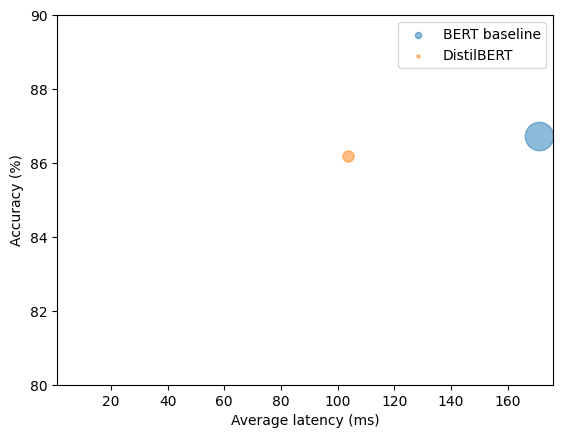

In [ ]:
plot_metrics(perf_metrics, optim_type)

The plot verifies what we've conculed by seeing the numbers. Next let's see if we can improve this with finding good values for $\alpha$ and T.

### Finding Good Hyperparameters with Optuna

To find  good values for $α$ and T, we could do a grid search over the 2D parameter space. But a much better alternative is to use [Optuna](https://optuna.org/), which is an optimization framework designe for just this type of task. Optuna formulates the search problem in terms of an objective function that is optimized through trials.

For example, we wan't to optimize Rosenbrock's banana function:

$f(x, y) = (a - x)^2 + b(y - x^2)^2$

Which is a famous test case for optimization frameworks. The function get's it's name from the cureved contours and has a global minimum at (1, 1). Finding the valley is an easy optimization problem but finding the global minimum is not.

*rosenbroc's banana optmization*

![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/8-Making-transformers-efficient-in-production/rosenbrock-banana-optimization.png?raw=1)

In [ ]:
# Let's find the global minimum for banana equation with optuna
# First defining he objective
def objective(trial):
  x = trial.suggest_float("x", -2, 2)
  y = trial.suggest_float("y", -2, 2)
  return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

`trial.suggest_float` specifies the parameter range to sample uniformly from. Optuna also proves `suggest_int` and `suggest_categorical` for integer and categorical values.

Optuna performs n number of trial on a study. We can pass the `objective()` to `study.optimize()` to find the optimal values. `study.best_parmas` gives the best parameters after trial are completed.

In [ ]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-09-22 08:41:46,681] A new study created in memory with name: no-name-d5588893-ac7d-417d-b285-3ec1c721fe95
[I 2023-09-22 08:41:46,686] Trial 0 finished with value: 75.13421487375204 and parameters: {'x': -1.4181619756694697, 'y': 1.178797015408381}. Best is trial 0 with value: 75.13421487375204.
[I 2023-09-22 08:41:46,691] Trial 1 finished with value: 64.63193936412874 and parameters: {'x': 0.3855729814382993, 'y': 0.9502550643711185}. Best is trial 1 with value: 64.63193936412874.
[I 2023-09-22 08:41:46,693] Trial 2 finished with value: 74.88261495564282 and parameters: {'x': -0.5901738573224415, 'y': 1.198916503559261}. Best is trial 1 with value: 64.63193936412874.
[I 2023-09-22 08:41:46,696] Trial 3 finished with value: 1906.1454393298936 and parameters: {'x': -1.586959355291433, 'y': -1.839831543490344}. Best is trial 1 with value: 64.63193936412874.
[I 2023-09-22 08:41:46,699] Trial 4 finished with value: 1143.474091772874 and parameters: {'x': -1.698680192134205, 'y': -0.

In [ ]:
study.best_params

{'x': 0.9766748679058, 'y': 0.9575073113845867}

Optuna has managed to find values that are reasonably close to x and y global minimum. We can do the same with hyperoparameter search. First let's define the range for out hyperparameters to be tuned.

In [ ]:
def hp_space(trial):
  return {
      "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
      "alpha": trial.suggest_float("alpha", 0, 1),
      "temperature": trial.suggest_int("temperature", 2, 20),
  }

Running the hyperparameter search with the `Trainer` is simple, just pass the hp_space to `trainer.hyperparameter_search()` and the directrion to optimize for, "maximum" for best results.

In [ ]:
best_run = distilbert_trainer.hyperparameter_search(
  n_trials=20,
  direction="maximize",
  hp_space=hp_space,
)

[I 2023-09-22 09:04:33,561] A new study created in memory with name: no-name-2ba8781e-e8f9-47a2-803b-dedd433db549
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.427400,0.223222,0.603226
2,0.187200,0.110226,0.820323
3,0.117100,0.074226,0.880323
4,0.090500,0.058795,0.898065
5,0.077400,0.051436,0.905161
6,0.071900,0.049225,0.904194


[I 2023-09-22 09:10:37,327] Trial 0 finished with value: 0.9041935483870968 and parameters: {'num_train_epochs': 6, 'alpha': 0.9011621094292266, 'temperature': 7}. Best is trial 0 with value: 0.9041935483870968.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.381500,0.193799,0.594839
2,0.161700,0.093681,0.833548
3,0.099500,0.061724,0.887097
4,0.074600,0.047201,0.901290
5,0.061100,0.038856,0.912581
6,0.053400,0.034098,0.920323
7,0.048200,0.031083,0.920323
8,0.044900,0.029182,0.923871
9,0.042800,0.028050,0.923226
10,0.041900,0.027701,0.923548


[I 2023-09-22 09:20:36,433] Trial 1 finished with value: 0.9235483870967742 and parameters: {'num_train_epochs': 10, 'alpha': 0.16036490360692157, 'temperature': 19}. Best is trial 1 with value: 0.9235483870967742.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.425300,0.218828,0.613548
2,0.181700,0.104068,0.834839
3,0.110300,0.067467,0.887742
4,0.082400,0.051273,0.903871
5,0.067800,0.042609,0.913548
6,0.059900,0.037955,0.915806
7,0.055200,0.035434,0.917097
8,0.052800,0.034567,0.919032


[I 2023-09-22 09:28:35,729] Trial 2 finished with value: 0.9190322580645162 and parameters: {'num_train_epochs': 8, 'alpha': 0.22042045305954294, 'temperature': 7}. Best is trial 1 with value: 0.9235483870967742.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.414600,0.211098,0.613871
2,0.174700,0.099192,0.839032
3,0.105100,0.063561,0.890323
4,0.077600,0.047662,0.906452
5,0.062900,0.038869,0.913226
6,0.054600,0.033966,0.920323
7,0.049200,0.030868,0.921613
8,0.045800,0.028956,0.927097
9,0.043600,0.027808,0.925806
10,0.042600,0.027458,0.927419


[I 2023-09-22 09:38:34,396] Trial 3 finished with value: 0.9274193548387096 and parameters: {'num_train_epochs': 10, 'alpha': 0.9430579267015337, 'temperature': 8}. Best is trial 3 with value: 0.9274193548387096.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.398000,0.202437,0.604194
2,0.168300,0.096526,0.835484
3,0.102400,0.062736,0.889677
4,0.076200,0.047482,0.904839
5,0.062100,0.038905,0.913226
6,0.054100,0.034053,0.920323
7,0.048800,0.030983,0.921290
8,0.045400,0.029071,0.925484
9,0.043300,0.027930,0.924516
10,0.042300,0.027579,0.925161


[I 2023-09-22 09:48:32,598] Trial 4 finished with value: 0.9251612903225807 and parameters: {'num_train_epochs': 10, 'alpha': 0.5742573194327758, 'temperature': 11}. Best is trial 3 with value: 0.9274193548387096.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.438300,0.224423,0.617742
2,0.185100,0.104055,0.842581
3,0.110200,0.065960,0.889032
4,0.081000,0.049234,0.907097
5,0.065700,0.040339,0.916129
6,0.057300,0.035420,0.920000


[I 2023-09-22 09:54:32,938] Trial 5 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.416600,0.215450,0.603871


[I 2023-09-22 09:55:34,212] Trial 6 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.458800,0.233719,0.627419
2,0.191300,0.105172,0.845806
3,0.111200,0.064971,0.893871
4,0.080300,0.047621,0.907419
5,0.064300,0.038616,0.918065
6,0.055600,0.033613,0.921935
7,0.050000,0.030541,0.922903
8,0.046400,0.028676,0.929355
9,0.044200,0.027561,0.927419
10,0.043300,0.027222,0.928710


[I 2023-09-22 10:05:32,144] Trial 7 finished with value: 0.9287096774193548 and parameters: {'num_train_epochs': 10, 'alpha': 0.962188981222633, 'temperature': 5}. Best is trial 7 with value: 0.9287096774193548.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.383200,0.195466,0.591935


[I 2023-09-22 10:06:34,067] Trial 8 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.382600,0.196191,0.585484


[I 2023-09-22 10:07:35,400] Trial 9 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.810000,0.432815,0.655806
2,0.341900,0.175816,0.820968


[I 2023-09-22 10:09:35,672] Trial 10 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.799600,0.407535,0.670000
2,0.307500,0.140561,0.850968
3,0.140400,0.071391,0.899677
4,0.089800,0.050576,0.916452
5,0.069500,0.041902,0.922903
6,0.059900,0.037149,0.929032
7,0.053800,0.034565,0.928387
8,0.050200,0.032828,0.929677
9,0.048000,0.031686,0.931290
10,0.047000,0.031432,0.930000


[I 2023-09-22 10:19:33,449] Trial 11 finished with value: 0.93 and parameters: {'num_train_epochs': 10, 'alpha': 0.9631707561555064, 'temperature': 2}. Best is trial 11 with value: 0.93.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.800700,0.409999,0.667742
2,0.311000,0.144034,0.848065
3,0.143800,0.073564,0.898065
4,0.092400,0.052177,0.915806
5,0.071800,0.043373,0.920968
6,0.062200,0.038631,0.927419
7,0.056200,0.036064,0.926774
8,0.052900,0.034543,0.928387
9,0.051200,0.033943,0.929355


[I 2023-09-22 10:28:31,640] Trial 12 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 9, 'alpha': 0.7614638279034733, 'temperature': 2}. Best is trial 11 with value: 0.93.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.800700,0.409999,0.667742
2,0.311000,0.144034,0.848065
3,0.143800,0.073564,0.898065
4,0.092400,0.052177,0.915806
5,0.071800,0.043373,0.920968
6,0.062200,0.038631,0.927419
7,0.056200,0.036064,0.926774
8,0.052900,0.034543,0.928387
9,0.051200,0.033943,0.929355


[I 2023-09-22 10:37:30,807] Trial 13 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 9, 'alpha': 0.7481225687324466, 'temperature': 2}. Best is trial 11 with value: 0.93.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.387800,0.197983,0.595161


[I 2023-09-22 10:38:31,771] Trial 14 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.497800,0.257750,0.625806
2,0.211200,0.117089,0.838065


[I 2023-09-22 10:40:32,904] Trial 15 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.399100,0.204982,0.597419


[I 2023-09-22 10:41:34,386] Trial 16 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.572700,0.293038,0.643871
2,0.233000,0.119771,0.850968
3,0.124800,0.068425,0.895806
4,0.086300,0.048976,0.911613
5,0.068200,0.040035,0.920645
6,0.059000,0.035225,0.923871
7,0.053400,0.032483,0.925806
8,0.050200,0.030929,0.927419


[I 2023-09-22 10:49:33,575] Trial 17 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.398000,0.202437,0.604194


[I 2023-09-22 10:50:34,514] Trial 18 pruned. 
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.388400,0.199307,0.591613


[I 2023-09-22 10:51:36,091] Trial 19 pruned. 


In [ ]:
best_run

BestRun(run_id='11', objective=0.93, hyperparameters={'num_train_epochs': 10, 'alpha': 0.9631707561555064, 'temperature': 2})

In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# Define a new repository to store our distilled model
distilled_ckpt = "JpChi/distilbert-base-uncasedfinetuned-clinc"
student_training_args.output_dir = distilled_ckpt

In [ ]:
distil_trainer = DistillationTrainer(
  model_init=student_init,
  teacher_model=teacher_model,
  args=student_training_args,
  train_dataset=clinc_enc["train"],
  eval_dataset=clinc_enc["validation"],
  compute_metrics=compute_metrics,
  tokenizer=student_tokenizer,
)

Cloning https://huggingface.co/JpChi/distilbert-base-uncasedfinetuned-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/256M [00:00<?, ?B/s]

Download file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360366.c2a7b40089f2.252.2:  60%|#####9 …

Download file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360110.c2a7b40089f2.252.0: 100%|#######…

Download file training_args.bin: 100%|##########| 3.06k/3.06k [00:00<?, ?B/s]

Download file runs/Sep22_05-19-39_c2a7b40089f2/1695360110.387191/events.out.tfevents.1695360110.c2a7b40089f2.2…

Download file runs/Sep22_03-35-21_c744ae687115/events.out.tfevents.1695355875.c744ae687115.556.0: 100%|#######…

Download file runs/Sep22_03-35-21_c744ae687115/1695355876.0146964/events.out.tfevents.1695355876.c744ae687115.…

Download file runs/Sep22_05-19-39_c2a7b40089f2/1695360366.171736/events.out.tfevents.1695360366.c2a7b40089f2.2…

Clean file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360366.c2a7b40089f2.252.2:   7%|7         …

Clean file runs/Sep22_05-19-39_c2a7b40089f2/events.out.tfevents.1695360110.c2a7b40089f2.252.0:   9%|9         …

Clean file runs/Sep22_03-35-21_c744ae687115/events.out.tfevents.1695355875.c744ae687115.556.0:  12%|#2        …

Clean file runs/Sep22_05-19-39_c2a7b40089f2/1695360110.387191/events.out.tfevents.1695360110.c2a7b40089f2.252.…

Clean file runs/Sep22_03-35-21_c744ae687115/1695355876.0146964/events.out.tfevents.1695355876.c744ae687115.556…

Clean file runs/Sep22_05-19-39_c2a7b40089f2/1695360366.171736/events.out.tfevents.1695360366.c2a7b40089f2.252.…

Clean file training_args.bin:  33%|###2      | 1.00k/3.06k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

In [ ]:
distil_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.132200,3.087147,0.751290
2,2.349000,1.528424,0.857097
3,1.141600,0.763884,0.916452
4,0.564400,0.467880,0.934516
5,0.311800,0.352594,0.944516
6,0.201800,0.312447,0.944516
7,0.149000,0.292366,0.948065
8,0.123900,0.288909,0.948387
9,0.111700,0.287984,0.947097
10,0.107300,0.285520,0.947419


TrainOutput(global_step=3180, training_loss=0.91667273455071, metrics={'train_runtime': 601.8717, 'train_samples_per_second': 253.376, 'train_steps_per_second': 5.284, 'total_flos': 827475185485200.0, 'train_loss': 0.91667273455071, 'epoch': 10.0})

In [ ]:
distil_trainer.push_to_hub("Training complete")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.06k [00:00<?, ?B/s]

To https://huggingface.co/JpChi/distilbert-base-uncasedfinetuned-clinc
   7e6f396..0149bd5  main -> main

   7e6f396..0149bd5  main -> main

To https://huggingface.co/JpChi/distilbert-base-uncasedfinetuned-clinc
   0149bd5..1953248  main -> main

   0149bd5..1953248  main -> main



'https://huggingface.co/JpChi/distilbert-base-uncasedfinetuned-clinc/commit/0149bd5ce09ca54e1e7bddba8157f8d57069fdec'

In [ ]:
distilled_ckpt = "JpChi/distilbert-base-uncasedfinetuned-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1499834060669,
  'time_avg_ms': 171.21201471000404,
  'time_std_ms': 45.75788180951539,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88107013702393,
  'time_avg_ms': 103.62454463000176,
  'time_std_ms': 35.47375366908967,
  'accuracy': 0.862},
 'Distillation': {'size_mb': 255.88107013702393,
  'time_avg_ms': 70.27917734001676,
  'time_std_ms': 10.6014310199151,
  'accuracy': 0.888}}

<ipython-input-28-0ed969e512e9>:31: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


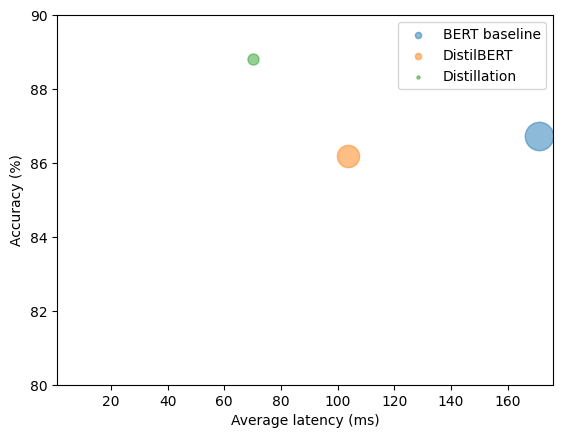

In [ ]:
plot_metrics(perf_metrics, optim_type)

In [ ]:
pd.DataFrame.from_dict(perf_metrics, orient="index")

,size_mb,time_avg_ms,time_std_ms,accuracy
BERT baseline,418.149983,171.212015,45.757882,0.867273
DistilBERT,255.881070,103.624545,35.473754,0.862000
Distillation,255.881070,70.279177,10.601431,0.888000


Woah, look at that with hyperparameter tuning, we've reduced the size by latency by 1/3rd. and increase in accuracy by 2%.

## Making Models Faster with Quantization

Knowledge distillation reduces the computational and memory needs by training a student model to mimic the teacher. Quantzation reduces the computational memory by reducing the data type to lower level precision like 8-bit integer (INT8) instead of 32-bit floating point. With reductuion in data types, memory storage for computations and matrix multiplication is reduced with not much loss in accuracy!

### A Primer on Floating-point and Fixed-point numbers

Most transformers today are pretrained with floating-point numbers(FP-16 or FP-32), since the provide the precision to accomodate the wide range of weights, activations and gradients. A floating-point number like FP32 represents a sequence of 32 bits grouped as sign, exponent and significand.

* sign - determines whether the number is positive or not
* significant - corresponds to the number of significant digits scaled to exponent in some fixed base(usually 2 for binary and 10 for decimal).

An example of this below:

In [ ]:
# Decimal
decimal = 137.035
# Floating-point32
fp32 = (-1)**0 * 1.37035 * 10**2
decimal, fp32, decimal == fp32

(137.035, 137.035, True)

In this:
* significand - 1.3705
* exponent - 10**2 in base 10
* sign - (-1)**0

Through the exponent we can represent a wide range of real numbers, and the decimal or floating point can be place anywhere relative to the significant digits(hence the name floating-point).

> **Note:**
  1. Low-precison data types allocate fewer bits.
  2. Fixed-point format uses less memory than floating-point. It's predetermined and fixed.

However, once the model is trained,we only need the forward pass to run inference, so we can reduce the precision of the data types without impacting the accuracy too much. For neural networks it is common to use a *fixed-point format* for the low-precision data types, where
* real numbers are represent as B-bit integers that are scaled by a common factor for all variables of the same type.
* We can control the range and precision of the fixed point number by controlling this scaling factor.

In [ ]:
# Fixed-point representation
flopoint = 137.035
fixpoint = 137035 # scaled by 1/1,000

The basic idea behing quantization is that we can `discretize` the floating-point values *f* in each tensor by mapping their range $[f_{\text{max}}, f_{\text{min}}]$ into a smaller one $[q_{\text{max}}, q_{\text{min}}]$ of fixed-point numbers *q*, and linearly distributing all the values in between. Mathametically, this mapping is described by the following equation:

$f = \left(\frac{{f_{\text{max}} - f_{\text{min}}}}{{q_{\text{max}} - q_{\text{min}}}}\right) (q - Z) = S(q - Z)$

where S is a positive floating-point number and the constant Z is the offset and has the same type as q. Z is called the *zero point* because it corresponds to the quantized value of the floating-point value f = 0. Note that the map needs to be *affine* to get the floating-point number when we dequantize the fixed-point ones.

*Quantization of fp to 8-bit int by Manas Sahni*

![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/8-Making-transformers-efficient-in-production/quantizing-floating-point-numbers.png?raw=1)

One of the main reasons transformers are prime candidates for quantization is the weights and activations range are quite small. We don't have to fit the entire FP32 numbers into 2**8 = 256 numbers represented by INT8. To see this, let's pick out one of the attention weight matrices from our distilled model and plot the frequency distribution of the values.

In [ ]:
# Load the model from huggingface hub
from transformers import AutoModelForSequenceClassification, pipeline

pipe = pipeline(
  "text-classification",
  "JpChi/distilbert-base-uncasedfinetuned-clinc"
)

# Visualizing the attention weight matrices distribution
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]

In [ ]:
weights.shape

torch.Size([768, 768])

In [ ]:
flattened_weights = weights.flatten()
flattened_weights.shape, 768 * 768

(torch.Size([589824]), 589824)

In [ ]:
import torch
print(f"Min: {torch.min(flattened_weights)}")
print(f"Max: {torch.max(flattened_weights)}")

Min: -0.6109962463378906
Max: 0.741598904132843


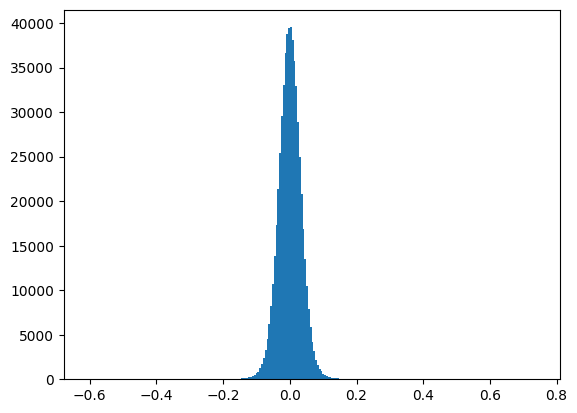

In [ ]:
# Plotting entire reange
plt.hist(flattened_weights.numpy(), bins=250)
plt.show();

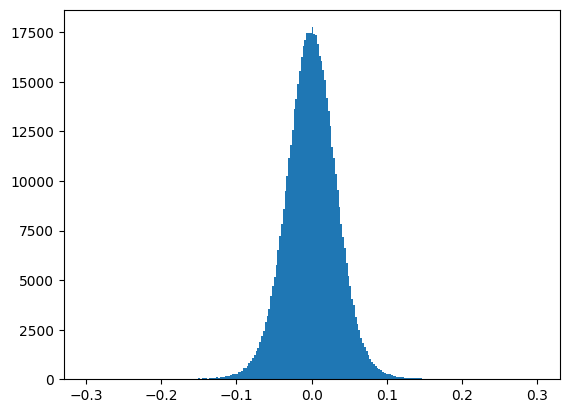

In [ ]:
# Plotting certain range reange
plt.hist(flattened_weights.numpy(), bins=250, range=(-0.3, 0.3))
plt.show();

In [ ]:
# Finding 95th percentile
import numpy as np
print(f"95th percent number in weights: {np.percentile(flattened_weights, 95)}")
print(f"90th percent number in weights: {np.percentile(flattened_weights, 90)}")
print(f"85th percent number in weights: {np.percentile(flattened_weights, 85)}")

95th percent number in weights: 0.054792796820402126
90th percent number in weights: 0.041962857916951264
85th percent number in weights: 0.033620247058570384


Most of the weights are distributed in the small range[-0.1, 0.1] around zero. Now, let's quantize the range of possible values for our integers is [-128, 128]. The zero point coincides with zero of FP32 and the scale factor is calculated with the previous equation:

In [ ]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))
scale

tensor(0.0053)

Let's create the quantized tensor by inverting the map(scale) plus zero_point and roung them to the nearest integer, and represent the result in the `torch.int8` datatype using the `Tensor.char()` function:

In [ ]:
# Clamp sets value beyond -127 and 127 to -127 and 126
quantized_weights = (weights / scale + zero_point).clamp(-128, 127).round().char()
quantized_weights, quantized_weights.shape

(tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
         [  9,   2,   1,  ...,  -4,   7,   1],
         [ -9,  -6,   5,  ...,   0,   5,  -4],
         ...,
         [  5,   0,  12,  ...,   0,   6,  -1],
         [  0,  -2, -12,  ...,  12,  -7, -13],
         [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8),
 torch.Size([768, 768]))

In [ ]:
# Size of each element in bits, float 4 bits and int 1 bit
weights.element_size(), quantized_weights.element_size()

(4, 1)

Great, we've just quantized our first tensor. In PyTorch we can do all these steps using `quantize_per_tensor()` function together with a quantized data type, `torch.qint`, that is optimized for integer arithmetic operations:

In [ ]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   5,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [ ]:
!pip install --upgrade matplotlib

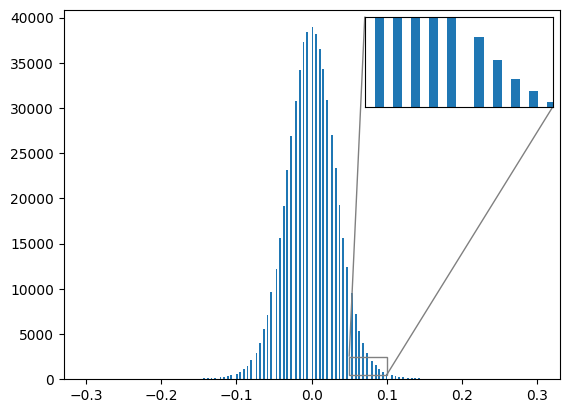

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

fig, ax = plt.subplots()
ax.hist(
   quantized_weights.dequantize().flatten().numpy(),
   bins=250,
   range=(-0.3, 0.3)
)
axins = zoomed_inset_axes(ax, 5, loc="upper right")
axins.hist(
  quantized_weights.dequantize().flatten().numpy(),
  bins=250,
  range=(-0.3, 0.3)
)
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

We can see the dicretization that's induced by mapping some weight values precisley and rounding the rest.

Next , let's compare how long it takes to compute the multiplication of two weight tensors with FP32 and INT8 values.

In [ ]:
%%timeit
weights @ weights

29.4 ms ± 9.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
from torch.nn.quantized import QFunctional
q_fn = QFunctional()

In [ ]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

498 µs ± 91.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Compared to our FP32 computation, using the INT8 tensors is almost 1000 times faster! Even large gains can be obtained by using dedicated backends for running quantized operators efficiently.

Since FP32 requires 4 bytes and INT8 requires 1byte the memeory will also be reduced, let's check that.

In [ ]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

<ipython-input-24-e8c20105a3d3>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

For a full-scale transformer, the actual compression rate depends on which layers are quantized.

Changing the precision for all computations in our model introduces small disturbances at each point in the computational graph, which can compound and affect model's performance. There are several ways to quantize a model. For deep neural networks, there are three main approaches:

#### Dynamic Quantization

With dynamic quantization nothing is changed during training and all weights are changed to INT8 ahead of inference time. In addition activation are also quantized. This is dynamic because quantization happens on the fly. One bottleneck is writing and reading from floating-point. This is the simplest quantization technique.

#### Static Quantization

Insted of computing the quantization of the activations on the fly, we can avoid the conversion of floating-point by precoomputing the quantization scheme. How is this done? We pass representative sample of data ahead of inference time and observe the activation patterns and then calculate, save the ideal quantization scheme. This enabels us to skip the conversion between INT8 and FP32 conversions. But this adds another additional step to the pipeline, as we need access to good data sample plus we need to find a good quantization scheme before inference. Static quantization does not account for difference in precision during training and inference, which leads to a performance drop in the model's metrics(e.g. accuracy).

#### Quantization-aware training

The effect of quantization can be "faked" during training by rounding of FP32 values during forward and backward pass. This improves performance in terms of model metrics over static and dynamic quantization.

The main bottleneck for running inference with transofrmers is the compute and memory bandwidth associated with the enormous numbers of weights in these models, so dynamic quantization is the current best approach for transformer-based models in NLP. In smaller computer vision model static quanitzation is generally used.

Also only lineart layers are quantized.

Let's implement dynamic quantization with PyTorch:

In [ ]:
from torch.quantization import quantize_dynamic
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch import nn

model_ckpt = "JpChi/distilbert-base-uncasedfinetuned-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### Benchmarking our quantized model

In [ ]:
from transformers import pipeline
from time import perf_counter
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model's size: 132.390362739563
Average Latency (ms) - 17.13 +/- 4.05
Accuracy on test set - 0.891


In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1499834060669,
  'time_avg_ms': 171.21201471000404,
  'time_std_ms': 45.75788180951539,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88107013702393,
  'time_avg_ms': 103.62454463000176,
  'time_std_ms': 35.47375366908967,
  'accuracy': 0.862},
 'Distillation': {'size_mb': 255.88107013702393,
  'time_avg_ms': 70.27917734001676,
  'time_std_ms': 10.6014310199151,
  'accuracy': 0.888},
 'Distillation + quantization': {'size_mb': 132.390362739563,
  'time_avg_ms': 17.131031569999777,
  'time_std_ms': 4.046519686823089,
  'accuracy': 0.8905454545454545}}

In [ ]:
pd.DataFrame.from_dict(perf_metrics, orient="index")

,size_mb,time_avg_ms,time_std_ms,accuracy
BERT baseline,418.149983,171.212015,45.757882,0.867273
DistilBERT,255.881070,103.624545,35.473754,0.862000
Distillation,255.881070,70.279177,10.601431,0.888000
Distillation + quantization,132.390363,17.131032,4.046520,0.890545


<ipython-input-16-0ed969e512e9>:31: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


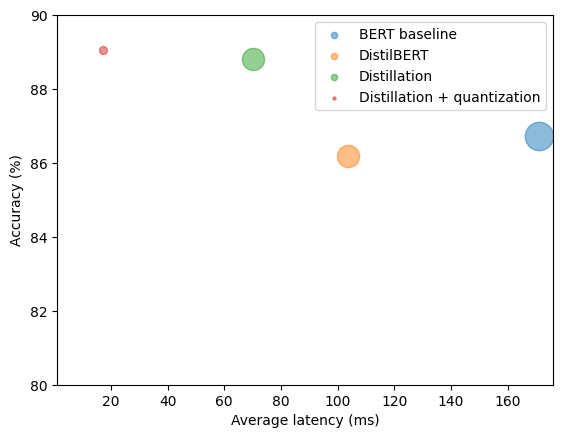

In [ ]:
plot_metrics(perf_metrics, optim_type)

Nice improvement. 1x improvement in accuracy and 6x decrease in size with quantization.

## Optimizing Inference with ONNX and the ONNX Runtime

ONNX is an open standard that defines a common set of operators to export models as a computational graph that represents flow of data thorugh network. It's also a common file format to represent deep learning models ina variety of frameworks including PyTorch, TensorFlow.

An example below, a section of the ONNX graph for BERT-base, visualized in Netron:

![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/8-Making-transformers-efficient-in-production/onnx-graph-of-a-section-of-BERT.png?raw=1)

By exposing a graph with standardized operators and data types, ONNX makes it easy to swtich between frameworks. For ex, a model trained in PyTorch can be exported to ONNX format and then imported in TensorFlow(and vice versa).

Where ONNX really shines is when it is coupled with a dedicated accelerator like ONNX Runtime, or ORT for short. ORT uses techniques like operator fusion and constant folding to optimize the ONNX graph, and defines an interface to *execution providers* that allows to run the model on different types of hardware. Below figures shows the high level architecture of the ONNX and ORT ecosystem:

![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/8-Making-transformers-efficient-in-production/onnx-and-onnx-runtime-ecosystem.png?raw=1)

To see ORT in action, the first thing we need to is convert our distilled model into the ONNX format. The transformers library has a build in function to this.

`convert_graph_to_onnx.convert()` this simplifies the following steps:

1. Intitialize the model as a `Pipeline`
2. Run placeholder inputs through the pipeline so the ONNX can record the computational graph
3. Define dynamic axes to handle dynamic sequence lengths
4. Save the graph with network parameters

To use this function, we first need tp set some [OpenMP](https://www.openmp.org/) env variables for ONNX:

In [2]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

OpenMP is an API designed for developing highly parallelized applications. The `OMP_NUM_THREADS` environment variable sets the number of threads to use for parallel computations in the onnx Runtime, while `OMP_WAIT_POLICY` specifies the waiting threads should be active(i.e, using CPU processor cycles).

Next let's convert our distilled model to the ONNX format. Here we need to specify the argument `pipeline_name="text-classification` since `convert()` wraps the model in a Transformers `pipeline()` function during conversion. In addition to the `model_ckpt`, we also pass the tokenizer to initialize the pipeline.